<a href="https://colab.research.google.com/github/aswanth523/melanoma/blob/main/aswanth_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [13]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [14]:
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/melanoma/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/melanoma/Test")

In [16]:
# print # of Images in Train and test folder
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [17]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [18]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size= (img_height, img_width),
    batch_size= batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [19]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size= (img_height, img_width),
    batch_size= batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [20]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

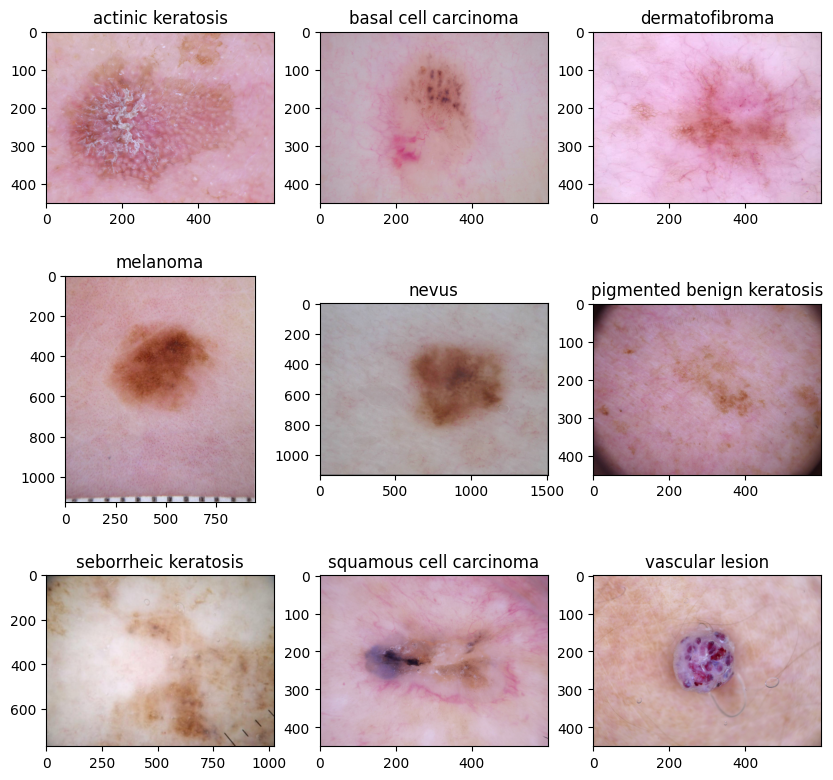

In [21]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

fig = plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

### 1 Random image of each class from Train dataset 

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [23]:
### Your code goes here
### Model 1 - Base Model
num_class=9

model=Sequential([
                  layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(180,180,3))
])
model.add(Conv2D(filters = 16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters = 32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters = 64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_class, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [24]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      18496     
                                                                 
 flatten (Flatten)           (None, 2073600)           0         
                                                                 
 dense (Dense)               (None, 128)               265420928 
                                                                 
 dense_1 (Dense)             (None, 9)                 1

### Train the model

In [26]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 790s 965ms/step - loss: 4.8049 - accuracy: 0.3718 - val_loss: 1.6455 - val_accuracy: 0.4246
Epoch 2/20
169/169 [==============================] - 20s 118ms/step - loss: 1.2650 - accuracy: 0.5406 - val_loss: 1.1162 - val_accuracy: 0.5917
Epoch 3/20
169/169 [==============================] - 20s 119ms/step - loss: 0.8827 - accuracy: 0.6957 - val_loss: 1.0684 - val_accuracy: 0.6548
Epoch 4/20
169/169 [==============================] - 20s 120ms/step - loss: 0.6696 - accuracy: 0.7821 - val_loss: 0.8728 - val_accuracy: 0.7290
Epoch 5/20
169/169 [==============================] - 21s 121ms/step - loss: 0.4974 - accuracy: 0.8409 - val_loss: 0.8943 - val_accuracy: 0.7112
Epoch 6/20
169/169 [==============================] - 21s 123ms/step - loss: 0.3851 - accuracy: 0.8830 - val_loss: 1.0506 - val_accuracy: 0.6860
Epoch 7/20
169/169 [==============================] - 21s 121ms/step - loss: 0.3070 - accuracy: 0.9091 - val_loss: 0.9517 - val_a

### Visualizing training results

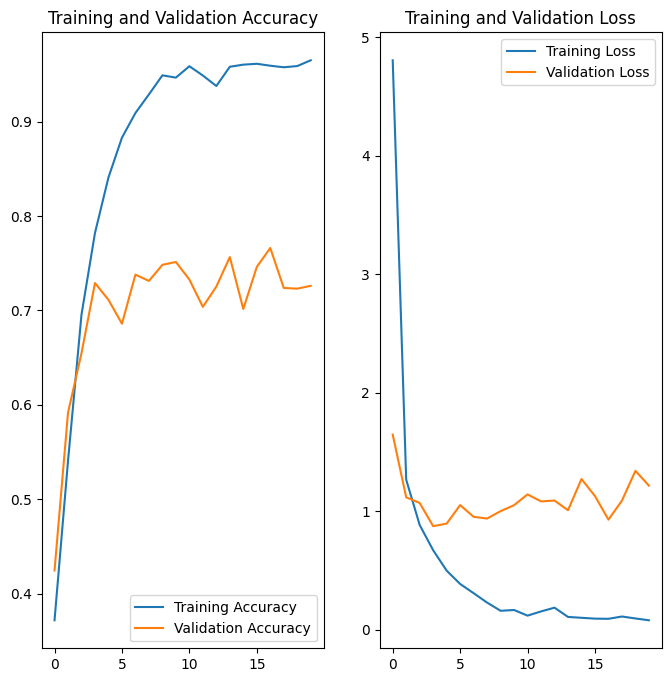

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit



```
# This is formatted as code
```

### Write your findings here
Observations of Model 1 :
*  loss: 0.2065 - accuracy: 0.9213 - val_loss: 2.5254 - val_accuracy: 0.4899

*  Although Model Accuracy of Train Dataset is 0.9213 whereas Accuracy of Validation Dataset if 0.4899 which is a evidence of model being OVERFIT.




In [28]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = Sequential([
                                layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
                                layers.experimental.preprocessing.RandomRotation(0.2),
])

Text(0.5, 1.0, 'seborrheic keratosis')

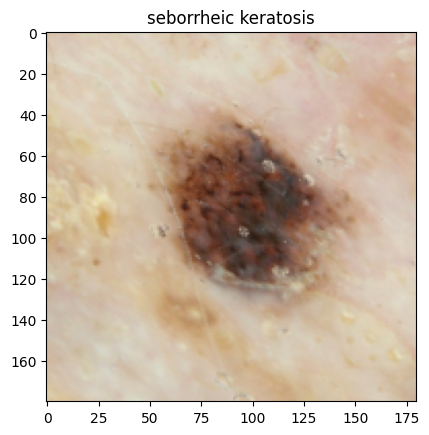

In [29]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
for img, labels in train_ds.take(1):
  aug_img = data_augmentation(img)

plt.imshow(aug_img[1].numpy().astype("uint8"))
plt.title(class_names[labels[1]])

### Todo:
### Create the model, compile and train the model


In [30]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here
## Model 2 :  We will use data_augmentation, rescaling , conv2D, maxpooling2D, Dropout 
num_class=9

model=Sequential([ 
                  data_augmentation,
                  layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(180,180,3))
])
model.add(Conv2D(filters = 16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_class, activation='softmax'))


### Compiling the model

In [31]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
# Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### Training the model

In [33]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 8s 30ms/step - loss: 2.1668 - accuracy: 0.1741 - val_loss: 1.9541 - val_accuracy: 0.2019
Epoch 2/20
169/169 [==============================] - 5s 27ms/step - loss: 1.8745 - accuracy: 0.2687 - val_loss: 1.7451 - val_accuracy: 0.3296
Epoch 3/20
169/169 [==============================] - 5s 29ms/step - loss: 1.7432 - accuracy: 0.3266 - val_loss: 1.5756 - val_accuracy: 0.3875
Epoch 4/20
169/169 [==============================] - 5s 27ms/step - loss: 1.6658 - accuracy: 0.3553 - val_loss: 1.5967 - val_accuracy: 0.4016
Epoch 5/20
169/169 [==============================] - 5s 30ms/step - loss: 1.6125 - accuracy: 0.3802 - val_loss: 1.6589 - val_accuracy: 0.3623
Epoch 6/20
169/169 [==============================] - 6s 34ms/step - loss: 1.5833 - accuracy: 0.3937 - val_loss: 1.5207 - val_accuracy: 0.4284
Epoch 7/20
169/169 [==============================] - 4s 27ms/step - loss: 1.6160 - accuracy: 0.3756 - val_loss: 1.4515 - val_accuracy: 0.4276

### Visualizing the results

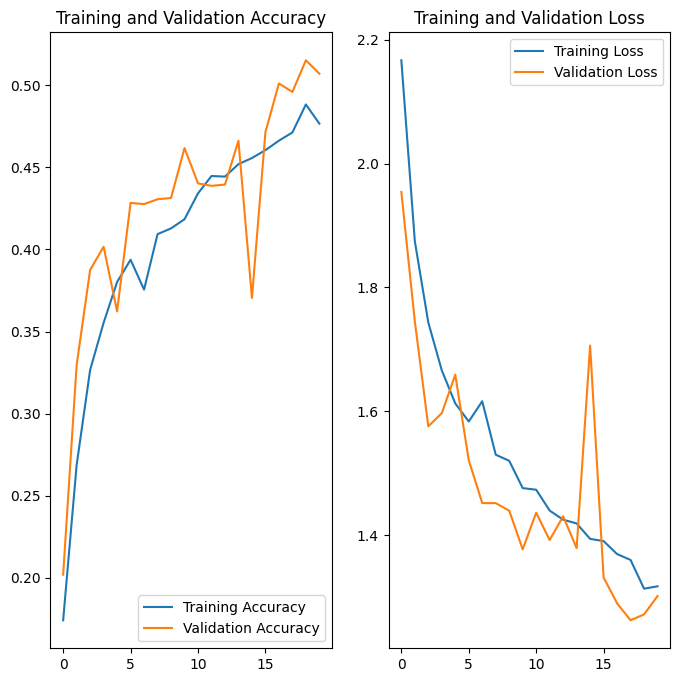

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Observation after data augmentation - Model 2
1.   Train Dataset Accuracy has come down to 0.5234 whereas Validation Dataset Accuracy is up to 0.5145
2.   Although Data Augmentation helped in fixing Overfitting problem as Train and Validation dataset Accuracy has very less difference .
3.   BUT as the accuracy is low this means Model is UNDERFITTING .



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [35]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:   
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df.head(10)

,Path,Label
0,/content/drive/MyDrive/melanoma/Train/actinic ...,actinic keratosis
1,/content/drive/MyDrive/melanoma/Train/actinic ...,actinic keratosis
2,/content/drive/MyDrive/melanoma/Train/actinic ...,actinic keratosis
3,/content/drive/MyDrive/melanoma/Train/actinic ...,actinic keratosis
4,/content/drive/MyDrive/melanoma/Train/actinic ...,actinic keratosis
5,/content/drive/MyDrive/melanoma/Train/actinic ...,actinic keratosis
6,/content/drive/MyDrive/melanoma/Train/actinic ...,actinic keratosis
7,/content/drive/MyDrive/melanoma/Train/actinic ...,actinic keratosis
8,/content/drive/MyDrive/melanoma/Train/actinic ...,actinic keratosis
9,/content/drive/MyDrive/melanoma/Train/actinic ...,actinic keratosis


<BarContainer object of 9 artists>

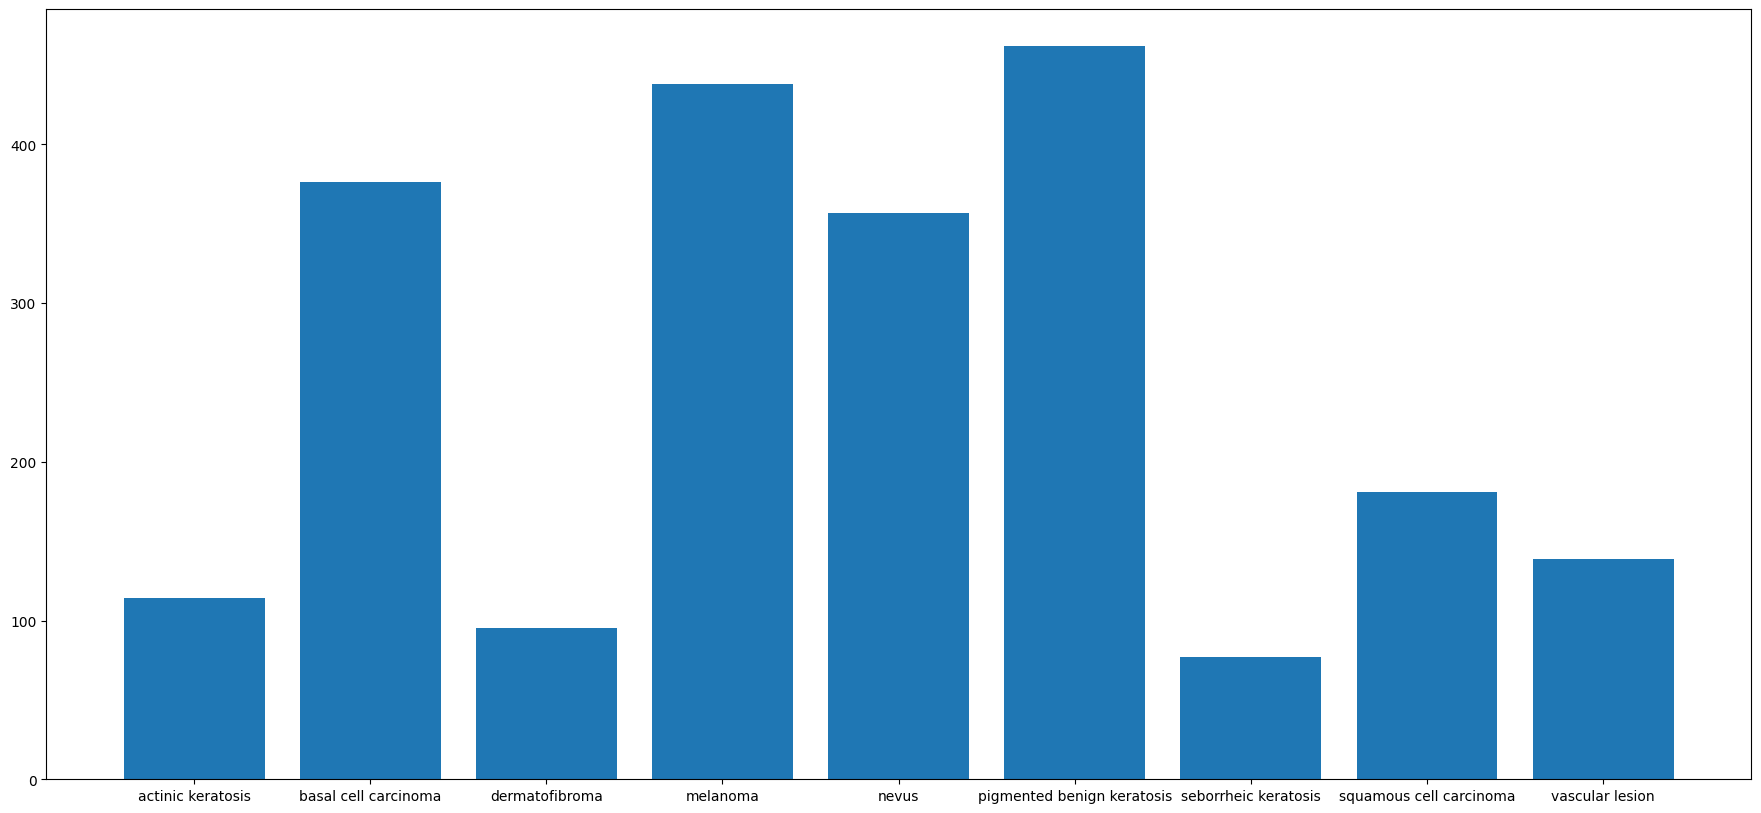

In [36]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(22,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
*  Ans:  Seborrheic keatosis has the least number of samples followed by dematofibroma sample


#### - Which classes dominate the data in terms proportionate number of samples?
*  Ans: pigmented benign keratosis has the higher samples followed by Melanoma and then nevus samples




#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [37]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [38]:
path_to_training_dataset="/content/drive/MyDrive/melanoma/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +"/"+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB124C46820>: 100%|██████████| 500/500 [00:25<00:00, 19.25 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB124D1E070>: 100%|██████████| 500/500 [00:27<00:00, 18.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB124E03880>: 100%|██████████| 500/500 [00:20<00:00, 24.37 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB124E0FCA0>: 100%|██████████| 500/500 [01:38<00:00,  5.07 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB1A00D7730>: 100%|██████████| 500/500 [01:37<00:00,  5.15 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB125741280>: 100%|██████████| 500/500 [00:21<00:00, 22.80 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FB124C516D0>: 100%|██████████| 500/500 [00:47<00:00, 10.56 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FB1257C8AC0>: 100%|██████████| 500/500 [00:21<00:00, 23.67 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/melanoma/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FB1C85D4640>: 100%|██████████| 500/500 [00:20<00:00, 24.16 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [39]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
# import glob
from glob import glob

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/melanoma/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032154.jpg_5c41d51e-6d8c-4853-bc34-c34f799157ae.jpg',
 '/content/drive/MyDrive/melanoma/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031852.jpg_28707d91-7001-4cbe-977d-364d8caab0c5.jpg',
 '/content/drive/MyDrive/melanoma/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026206.jpg_7ac8c762-e29f-4872-87b5-fd9d36cf31cc.jpg',
 '/content/drive/MyDrive/melanoma/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030827.jpg_9336a493-c71e-428d-90cc-c82134d60c74.jpg',
 '/content/drive/MyDrive/melanoma/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031659.jpg_09a33e59-93a6-40c6-bb4f-5236c214eeb0.jpg',
 '/content/drive/MyDrive/melanoma/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0032947.jpg_f0f80892-a56d-4711-86db-3ce557f667fb.jpg',
 '/content/drive

In [41]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [42]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [43]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-43-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [44]:
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [46]:
data_dir_train="/content/drive/MyDrive/melanoma/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [48]:
## Model 3 - We will use rescaling , conv2D, maxpool2D, Dropout and model.add(BatchNormalization())

num_class=9

model=Sequential([ 
                  layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(180,180,3))
])
model.add(Conv2D(filters = 16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_class, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [49]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
# Model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 178, 178, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 16)      

#### **Todo:**  Train your model

In [51]:
### Using epochs = 50 as it given below in the notebook . 

epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
281/281 [==============================] - 71s 202ms/step - loss: 3.9852 - accuracy: 0.2909 - val_loss: 22.3722 - val_accuracy: 0.0992
Epoch 2/50
281/281 [==============================] - 56s 195ms/step - loss: 1.6409 - accuracy: 0.3664 - val_loss: 2.8855 - val_accuracy: 0.3413
Epoch 3/50
281/281 [==============================] - 54s 190ms/step - loss: 1.5120 - accuracy: 0.4260 - val_loss: 1.7510 - val_accuracy: 0.4330
Epoch 4/50
281/281 [==============================] - 55s 192ms/step - loss: 1.4069 - accuracy: 0.4607 - val_loss: 2.4749 - val_accuracy: 0.3031
Epoch 5/50
281/281 [==============================] - 54s 189ms/step - loss: 1.2739 - accuracy: 0.5096 - val_loss: 1.2774 - val_accuracy: 0.5527
Epoch 6/50
281/281 [==============================] - 54s 188ms/step - loss: 1.1992 - accuracy: 0.5454 - val_loss: 2.5403 - val_accuracy: 0.4121
Epoch 7/50
281/281 [==============================] - 54s 190ms/step - loss: 1.0939 - accuracy: 0.5865 - val_loss: 0.8649 - val_a

#### **Todo:**  Visualize the model results

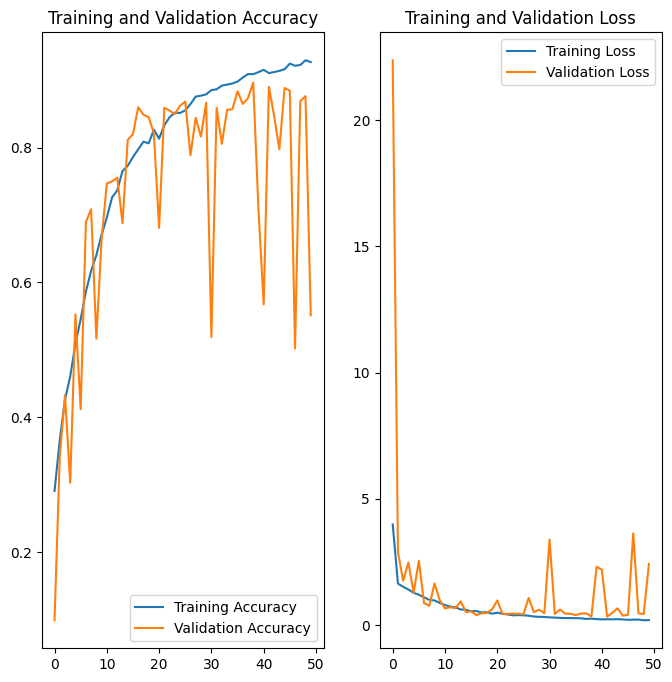

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

**Observations of Model 3 **
*   Model 3 with BN + 50 epochs (as recommended in notebook) + FC = 256 - Class Rebalance helped to increase the Train and Validation accuracy but could be further improved by increasing the parameters of Dense layer to 512 as below. 

*   Model 3 with BN + 50 epochs (as recommended in notebook) + FC = 512 has better Train and Validation accuracy 

*   Train and Validation accuracy has lesser difference .

*   Training Accuracy increase whereas Validation accuracy fluctuates a lot

